In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [45]:
def get_data(year, month, start_day, start_hour, end_day, end_hour, directions):
    year_string = str(year)
    url = f'https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.html?dataset=Datasets/cpc_global_precip/precip.{year_string}.nc'
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    first_time = pd.Timestamp(year, month, start_day, start_hour)
    last_time = pd.Timestamp(year, month, end_day, end_hour)
    ds_timesliced = ds.sel(time=slice(first_time, last_time))
    #ds_sliced = ds_timesliced.sel(lat=slice(directions['North'], directions['South']), lon=slice(directions['West'], directions['East']))

    return ds_timesliced

def plot_data(ds, directions):
    for i in range (0, 1):
        ds = ds.isel(time=i)
        time = ds.time.values
        int_datetime_index = pd.DatetimeIndex([time])
        levels = [0.3, 2.5, 6.4, 12.7, 19.1, 25.4, 38.1, 50.8, 63.5, 76.2]
        colors = ['#c9e7f0', '#95cbd5', '#6f98d0', '#45539e', '#8fbf5c', '#80ba55', '#568a4c', '#e4e44e', '#dcba60', '#d08c39', '#c43b33']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

        # Add the land and ocean features in the background
        ax.add_feature(cfeature.LAND, color='#fbf5ea')
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')

        # Now plot the precipitation on top
        precip = ax.contourf(ds['lon'], ds['lat'], ds['precip'], levels=levels, cmap=cmap, extend='max', norm=norm)
        plt.colorbar(precip, ax=ax, orientation='vertical', label='mm/day', fraction=0.046, pad=0.04)

        # Add coastlines, borders, and other features
        ax.set_extent([directions['West']+25, directions['East'], 30, directions['North']-5])
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)

        # Creating the legend with the custom entries

        plt.title(f'CPC 24-Hour Precipitation Analysis for {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False

        plt.show()


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.html?dataset=Datasets/cpc_global_precip/precip.2019.nc returned HTML. Changing to: https://psl.noaa.gov/thredds/catalog/Datasets/cpc_global_precip/catalog.xml?dataset=Datasets/cpc_global_precip/precip.2019.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


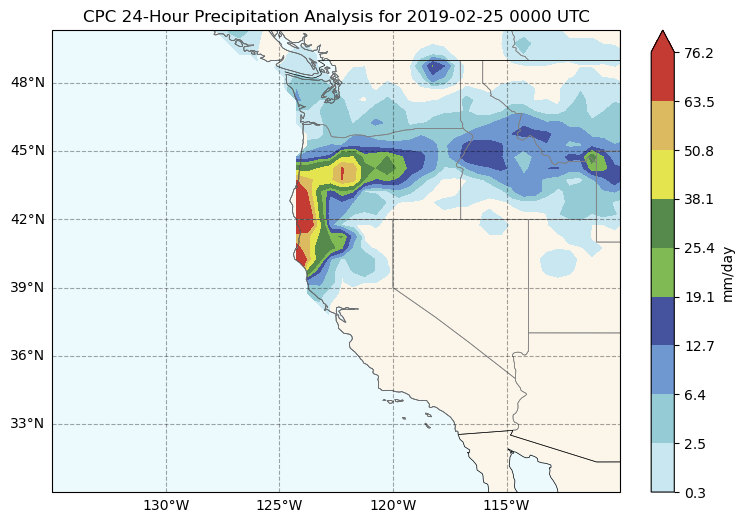

In [46]:
if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200} #units: degrees North, degrees East
    year = 2019
    month = 2
    start_day = 25
    start_hour = 0
    end_day = 25
    end_hour = 23
    year_string = str(year)

    ds = get_data(year, month, start_day, start_hour, end_day, end_hour, directions)
    plot_data(ds, directions)